In [ ]:
#1 install catboost module
#2.rerun all to have cols hospital and call to dispatch, chech categories nefore model
#3.run with 300 iterations and new depth
#4.calcuate score of determination, mae


In [61]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

In [94]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [95]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']

time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [96]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

In [7]:
# call_type = ['Medical Incident', 'Structure Fire', 'Alarms']

# def get_group(x):
#     if x in call_type:
#         return x
#     else:
#         return 'Other'

# df['Call Type Merged'] = df['Call Type'].map(get_group)

In [97]:
def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

#     w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
#     call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
#     call_types_shares = w.tolist() #makes values of shares a list
#     df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

In [98]:
df = df[df['Respond to Available'].notnull()]

In [173]:
#------cancelled dropping of 'Call to Dispatch','Minutes','Month', 'WeekDay', 'Call Type', 
df = df.drop(columns=['Call Number','Unit ID', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm',
                      'Address', 'City', 'Zipcode of Incident', 'Priority', 'Final Priority', 'Number of Alarms',
                      'Unit sequence in call dispatch', 'Neighborhooods - Analysis Boundaries', 'Location', 
                      'RowID', 'Battalion', 'ALS Unit', 'Weekofyear', 'Minutes','Month', 'WeekDay',
                      'Fire Prevention District', 'Supervisor District'], errors='ignore')

In [128]:
df = df.dropna(how='any') 

In [174]:
df.head()

,Call Type,Station Area,Box,Original Priority,Unit Type,Respond to Available,Call to Dispatch,Hours,Hospital or Transport
1,Medical Incident,23,7651.0,3,MEDIC,4306.0,87.0,21,1
3,Alarms,1,1456.0,3,ENGINE,501.0,26.0,21,0
4,Medical Incident,1,1322.0,3,RESCUE SQUAD,136.0,101.0,21,0
5,Citizen Assist / Service Call,3,1463.0,3,TRUCK,1038.0,43.0,21,0
6,Electrical Hazard,38,3155.0,3,ENGINE,577.0,171.0,21,0


In [146]:
y = df['Respond to Available']
X = df.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [147]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1433371 entries, 1 to 1650183
Data columns (total 8 columns):
Call Type                1433371 non-null object
Station Area             1433371 non-null object
Box                      1433371 non-null float64
Original Priority        1433371 non-null object
Unit Type                1433371 non-null object
Call to Dispatch         1433371 non-null float64
Hours                    1433371 non-null int64
Hospital or Transport    1433371 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 98.4+ MB


In [148]:
cat_features=[
    0,
    1,
    3,
    4
]

In [149]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [162]:
model = CatBoostRegressor(iterations=700, depth=5,learning_rate=0.1)
model.fit(train_pool)

0:	learn: 2087.0921851	total: 1.05s	remaining: 12m 14s
1:	learn: 1961.4149564	total: 1.78s	remaining: 10m 19s
2:	learn: 1853.3771074	total: 2.36s	remaining: 9m 7s
3:	learn: 1760.9789913	total: 3.11s	remaining: 9m 1s
4:	learn: 1682.4182305	total: 3.87s	remaining: 8m 58s
5:	learn: 1615.9184194	total: 4.78s	remaining: 9m 12s
6:	learn: 1559.9485977	total: 5.55s	remaining: 9m 9s
7:	learn: 1513.0350496	total: 6.43s	remaining: 9m 16s
8:	learn: 1473.9657993	total: 7.3s	remaining: 9m 20s
9:	learn: 1441.3815668	total: 8.2s	remaining: 9m 25s
10:	learn: 1414.3927734	total: 8.91s	remaining: 9m 18s
11:	learn: 1392.1180617	total: 10.2s	remaining: 9m 44s
12:	learn: 1372.4562386	total: 11.2s	remaining: 9m 50s
13:	learn: 1356.1355771	total: 12.1s	remaining: 9m 51s
14:	learn: 1342.3701270	total: 12.8s	remaining: 9m 46s
15:	learn: 1330.8687818	total: 13.6s	remaining: 9m 39s
16:	learn: 1321.1553725	total: 14.3s	remaining: 9m 32s
17:	learn: 1313.0561965	total: 15.2s	remaining: 9m 35s
18:	learn: 1306.3609952

148:	learn: 1240.0632309	total: 2m 2s	remaining: 7m 31s
149:	learn: 1240.0559015	total: 2m 2s	remaining: 7m 29s
150:	learn: 1240.0351938	total: 2m 3s	remaining: 7m 28s
151:	learn: 1239.8918378	total: 2m 4s	remaining: 7m 27s
152:	learn: 1239.8360578	total: 2m 4s	remaining: 7m 26s
153:	learn: 1239.7328215	total: 2m 5s	remaining: 7m 24s
154:	learn: 1239.6950056	total: 2m 6s	remaining: 7m 23s
155:	learn: 1239.6478700	total: 2m 6s	remaining: 7m 21s
156:	learn: 1239.6034331	total: 2m 7s	remaining: 7m 21s
157:	learn: 1239.5721190	total: 2m 8s	remaining: 7m 19s
158:	learn: 1239.5416392	total: 2m 8s	remaining: 7m 18s
159:	learn: 1239.4855488	total: 2m 9s	remaining: 7m 17s
160:	learn: 1239.4682725	total: 2m 10s	remaining: 7m 17s
161:	learn: 1239.4462384	total: 2m 11s	remaining: 7m 16s
162:	learn: 1239.4075230	total: 2m 12s	remaining: 7m 16s
163:	learn: 1239.1255133	total: 2m 13s	remaining: 7m 15s
164:	learn: 1239.0586061	total: 2m 14s	remaining: 7m 15s
165:	learn: 1238.9496123	total: 2m 15s	rema

294:	learn: 1230.7964656	total: 4m 21s	remaining: 5m 59s
295:	learn: 1230.7803011	total: 4m 22s	remaining: 5m 58s
296:	learn: 1230.7038515	total: 4m 23s	remaining: 5m 57s
297:	learn: 1230.6970866	total: 4m 24s	remaining: 5m 57s
298:	learn: 1230.6945576	total: 4m 25s	remaining: 5m 56s
299:	learn: 1230.6115802	total: 4m 26s	remaining: 5m 55s
300:	learn: 1230.5917843	total: 4m 27s	remaining: 5m 54s
301:	learn: 1230.1423799	total: 4m 28s	remaining: 5m 54s
302:	learn: 1230.1328583	total: 4m 29s	remaining: 5m 53s
303:	learn: 1230.0901156	total: 4m 30s	remaining: 5m 52s
304:	learn: 1230.0755899	total: 4m 32s	remaining: 5m 52s
305:	learn: 1230.0376551	total: 4m 32s	remaining: 5m 51s
306:	learn: 1230.0191698	total: 4m 33s	remaining: 5m 50s
307:	learn: 1230.0087330	total: 4m 35s	remaining: 5m 50s
308:	learn: 1229.9819099	total: 4m 35s	remaining: 5m 49s
309:	learn: 1229.9658833	total: 4m 37s	remaining: 5m 49s
310:	learn: 1229.9539330	total: 4m 38s	remaining: 5m 48s
311:	learn: 1229.9477364	total:

439:	learn: 1225.9337680	total: 6m 37s	remaining: 3m 55s
440:	learn: 1225.9305931	total: 6m 38s	remaining: 3m 54s
441:	learn: 1225.9263348	total: 6m 39s	remaining: 3m 53s
442:	learn: 1225.8569382	total: 6m 40s	remaining: 3m 52s
443:	learn: 1225.8181146	total: 6m 41s	remaining: 3m 51s
444:	learn: 1225.8028895	total: 6m 41s	remaining: 3m 50s
445:	learn: 1225.7984848	total: 6m 42s	remaining: 3m 49s
446:	learn: 1225.7519494	total: 6m 43s	remaining: 3m 48s
447:	learn: 1225.7241032	total: 6m 44s	remaining: 3m 47s
448:	learn: 1225.6984681	total: 6m 44s	remaining: 3m 46s
449:	learn: 1225.6923457	total: 6m 45s	remaining: 3m 45s
450:	learn: 1225.6871867	total: 6m 46s	remaining: 3m 44s
451:	learn: 1225.6837845	total: 6m 47s	remaining: 3m 43s
452:	learn: 1225.6817320	total: 6m 47s	remaining: 3m 42s
453:	learn: 1225.6733034	total: 6m 48s	remaining: 3m 41s
454:	learn: 1225.6355311	total: 6m 49s	remaining: 3m 40s
455:	learn: 1225.6002930	total: 6m 49s	remaining: 3m 39s
456:	learn: 1225.5932525	total:

584:	learn: 1222.3577479	total: 8m 37s	remaining: 1m 41s
585:	learn: 1222.3546802	total: 8m 38s	remaining: 1m 40s
586:	learn: 1222.3237818	total: 8m 39s	remaining: 1m 40s
587:	learn: 1222.3062024	total: 8m 40s	remaining: 1m 39s
588:	learn: 1222.2585072	total: 8m 42s	remaining: 1m 38s
589:	learn: 1222.2569027	total: 8m 42s	remaining: 1m 37s
590:	learn: 1222.2524438	total: 8m 43s	remaining: 1m 36s
591:	learn: 1222.2409500	total: 8m 44s	remaining: 1m 35s
592:	learn: 1222.2370275	total: 8m 45s	remaining: 1m 34s
593:	learn: 1222.2234795	total: 8m 46s	remaining: 1m 33s
594:	learn: 1222.2104833	total: 8m 47s	remaining: 1m 33s
595:	learn: 1222.2091071	total: 8m 47s	remaining: 1m 32s
596:	learn: 1222.1826114	total: 8m 48s	remaining: 1m 31s
597:	learn: 1222.1743644	total: 8m 49s	remaining: 1m 30s
598:	learn: 1222.0348213	total: 8m 50s	remaining: 1m 29s
599:	learn: 1222.0320672	total: 8m 51s	remaining: 1m 28s
600:	learn: 1222.0241552	total: 8m 51s	remaining: 1m 27s
601:	learn: 1222.0222562	total:

In [163]:
model.score(test_pool, y_test)  #rmse score. mse= 1689**0.5 = 41!!!!

1160.5533620730714

In [164]:
pred = model.predict(test_pool)

In [165]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = pred
XYY['y_test-y_pred'] = XYY['y_test']-XYY['y_pred']
XYY['y_test-y_pred_squared'] = XYY['y_test-y_pred']**2
mean_y = XYY['y_pred'].mean()
XYY['mean_y'] = mean_y
XYY['diff'] = XYY['y_test']-XYY['mean_y']
XYY.head(2)

,Call Type,Station Area,Box,Original Priority,Unit Type,Call to Dispatch,Hours,Hospital or Transport,y_test,y_pred,y_test-y_pred,y_test-y_pred_squared,mean_y,diff
1650184,Medical Incident,18,7572.0,2,ENGINE,160.0,17,0,1766.0,1156.769253,609.230747,3.711621e+05,1446.784115,319.215885
1650186,Medical Incident,18,7572.0,2,MEDIC,160.0,17,0,70.0,1561.650713,-1491.650713,2.225022e+06,1446.784115,-1376.784115


In [166]:
mae = (abs(XYY['y_test-y_pred']).sum())/len(XYY['y_test-y_pred'])
mse = (XYY['y_test-y_pred']**2).sum()/len(XYY['y_test-y_pred'])
rmse = mse**0.5
determanation_score = 1-((XYY['y_test-y_pred']**2).sum())/((XYY['diff']**2).sum())

In [167]:
mae

642.5944121584081

In [168]:
mse

1346884.1062191094

In [169]:
rmse

1160.5533620730714

In [170]:
determanation_score

0.5591355736519035

In [171]:
#scores compare to mean
total_mean = y_train.mean()
mae_mean = (abs(XYY['y_test']-total_mean).sum())/len(XYY['y_test-y_pred'])
print('mae_mean: '+ str(mae_mean))
mse_mean = ((XYY['y_test']-total_mean)**2).sum()/len(XYY['y_test-y_pred'])
print('mse_mean: '+ str(mse_mean))
rmse_mean = mse_mean**0.5
print('mrse_mean: '+ str(rmse_mean))

mae_mean: 1329.0145312135012
mse_mean: 3051247.0388752143
mrse_mean: 1746.781909362246


In [172]:
val = model.get_feature_importance()
feat = X_test.columns

list(zip(feat,val))

[('Call Type', 11.422707035154426),
 ('Station Area', 4.37997298354878),
 ('Box', 10.075601350175935),
 ('Original Priority', 1.7568362013953736),
 ('Unit Type', 13.58421355316452),
 ('Call to Dispatch', 7.874245698312318),
 ('Hours', 6.040120995592726),
 ('Hospital or Transport', 44.866302182655915)]

[('Battalion', 0.5078027445356504),
 ('Station Area', 6.135001357254266),
 ('Box', 9.114046028348575),
 ('Original Priority', 1.9631004892661137),
 ('ALS Unit', 0.8674294353822795),
 ('Call Type Group', 3.333459641176911),
 ('Unit Type', 41.73743300645736),
 ('Fire Prevention District', 1.5738692854230882),
 ('Supervisor District', 1.5693252610655513),
 ('Month', 0.5003596981995669),
 ('WeekDay', 0.7519625648056559),
 ('Weekofyear', 1.623724419771495),
 ('Hours', 8.179958110857296),
 ('Minutes', 1.0530441606569498),
 ('Call Type Merged', 21.08948379679924)]
 
 [('Station Area', 6.994516107181966),
 ('Box', 5.876354709490432),
 ('Original Priority', 0.9627007503785607),
 ('Call Type Group', 1.29599635276719),
 ('Unit Type', 60.51084666020504),
 ('Fire Prevention District', 0.3122714646717646),
 ('Supervisor District', 0.5588749902917611),
 ('Weekofyear', 0.0),
 ('Hours', 3.0604472528149556),
 ('Minutes', 0.0),
 ('Call Type Merged', 20.427991712198327)]

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

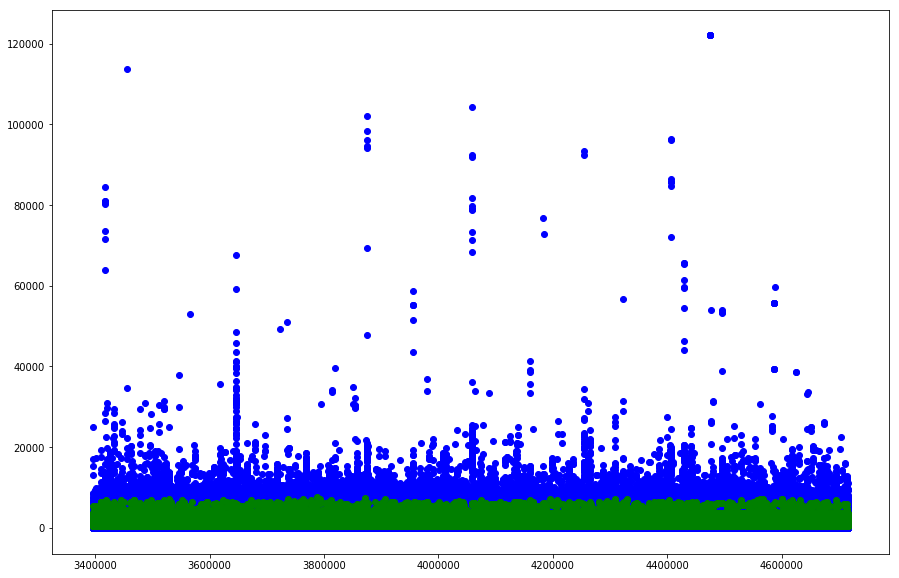

In [76]:
XYY = XYY.sort_values('y_test')
plt.figure(figsize=(15,10))
plt.scatter(XYY.index, XYY['y_test'].sort_values(), color='b')
plt.scatter(XYY.index, XYY['y_pred'], color='g')
plt.show()

In [ ]:
m